# Sub Question Query Engine as a workflow with GraphRAG

LlamaIndex has a built-in Sub-Question Query Engine. Here, we replace it with a Workflow-based equivalent and intergrate it with the GraphRAG pipeline.

[GraphRAG (Graphs + Retrieval Augmented Generation)](https://www.microsoft.com/en-us/research/project/graphrag/) combines the strengths of Retrieval Augmented Generation (RAG) and Query-Focused Summarization (QFS) to effectively handle complex queries over large text datasets. While RAG excels in fetching precise information, it struggles with broader queries that require thematic understanding, a challenge that QFS addresses but cannot scale well. GraphRAG integrates these approaches to offer responsive and thorough querying capabilities across extensive, diverse text corpora.

This notebook provides guidance on constructing the GraphRAG pipeline using the LlamaIndex PropertyGraph abstractions using Neo4J.

This notebook updates the GraphRAG pipeline to v2. If you haven’t checked v1 yet, you can find it [here](https://github.com/run-llama/llama_index/blob/main/docs/docs/examples/cookbooks/GraphRAG_v1.ipynb). Following are the updates to the existing implementation:

1. Integrate with Neo4J Graph database.
2. Embedding based retrieval.



First we install our dependencies:
* LlamaIndex core for most things
* OpenAI LLM and embeddings for LLM actions
* `graspologic` is used to use hierarchical_leiden for building communities.
* `llama-index-readers-file` to power the PDF reader in `SimpleDirectoryReader`

In [1]:
%pip install -U llama-index-core llama-index-llms-openai llama-index-embeddings-openai llama-index-readers-file llama-index-utils-workflow llama-index-graph-stores-neo4j graspologic numpy scipy

  Using cached numpy-2.1.0-cp312-cp312-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached scipy-1.14.1-cp312-cp312-macosx_14_0_arm64.whl.metadata (60 kB)
Note: you may need to restart the kernel to use updated packages.


Bring in our dependencies as imports:

In [ ]:
import os, json
import pandas as pd
import openai as ai
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    load_index_from_storage,
)
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent,
)
from llama_index.core.agent import ReActAgent
from llama_index.llms.openai import OpenAI
from llama_index.utils.workflow import draw_all_possible_flows
from llama_index.core import Document, Settings
from llama_index.core.node_parser import SentenceSplitter
from llama_index.embeddings.openai import OpenAIEmbedding
ai.api_key = ""
ai.base_url = ""
os.environ["OPENAI_API_KEY"] = ai.api_key
os.environ["OPENAI_API_BASE"] = ai.base_url
Settings.llm = OpenAI(model="gpt-4")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-large", additional_kwargs={"encoding_format": "float"})
llm = Settings.llm

## GraphRAGExtractor

The GraphRAGExtractor class is designed to extract triples (subject-relation-object) from text and enrich them by adding descriptions for entities and relationships to their properties using an LLM.

This functionality is similar to that of the `SimpleLLMPathExtractor`, but includes additional enhancements to handle entity, relationship descriptions. For guidance on implementation, you may look at similar existing [extractors](https://docs.llamaindex.ai/en/latest/examples/property_graph/Dynamic_KG_Extraction/?h=comparing).

Here's a breakdown of its functionality:

**Key Components:**

1. `llm:` The language model used for extraction.
2. `extract_prompt:` A prompt template used to guide the LLM in extracting information.
3. `parse_fn:` A function to parse the LLM's output into structured data.
4. `max_paths_per_chunk:` Limits the number of triples extracted per text chunk.
5. `num_workers:` For parallel processing of multiple text nodes.


**Main Methods:**

1. `__call__:` The entry point for processing a list of text nodes.
2. `acall:` An asynchronous version of __call__ for improved performance.
3. `_aextract:` The core method that processes each individual node.


**Extraction Process:**

For each input node (chunk of text):
1. It sends the text to the LLM along with the extraction prompt.
2. The LLM's response is parsed to extract entities, relationships, descriptions for entities and relations.
3. Entities are converted into EntityNode objects. Entity description is stored in metadata
4. Relationships are converted into Relation objects. Relationship description is stored in metadata.
5. These are added to the node's metadata under KG_NODES_KEY and KG_RELATIONS_KEY.

**NOTE:** In the current implementation, we are using only relationship descriptions. In the next implementation, we will utilize entity descriptions during the retrieval stage.

In [3]:
import asyncio
import nest_asyncio

nest_asyncio.apply()

from typing import Any, List, Callable, Optional, Union, Dict
from IPython.display import Markdown, display

from llama_index.core.async_utils import run_jobs
from llama_index.core.indices.property_graph.utils import (
    default_parse_triplets_fn,
)
from llama_index.core.graph_stores.types import (
    EntityNode,
    KG_NODES_KEY,
    KG_RELATIONS_KEY,
    Relation,
)
from llama_index.core.llms.llm import LLM
from llama_index.core.prompts import PromptTemplate
from llama_index.core.prompts.default_prompts import (
    DEFAULT_KG_TRIPLET_EXTRACT_PROMPT,
)
from llama_index.core.schema import TransformComponent, BaseNode
from llama_index.core.bridge.pydantic import BaseModel, Field


class GraphRAGExtractor(TransformComponent):
    """Extract triples from a graph.

    Uses an LLM and a simple prompt + output parsing to extract paths (i.e. triples) and entity, relation descriptions from text.

    Args:
        llm (LLM):
            The language model to use.
        extract_prompt (Union[str, PromptTemplate]):
            The prompt to use for extracting triples.
        parse_fn (callable):
            A function to parse the output of the language model.
        num_workers (int):
            The number of workers to use for parallel processing.
        max_paths_per_chunk (int):
            The maximum number of paths to extract per chunk.
    """

    llm: LLM
    extract_prompt: PromptTemplate
    parse_fn: Callable
    num_workers: int
    max_paths_per_chunk: int

    def __init__(
        self,
        llm: Optional[LLM] = None,
        extract_prompt: Optional[Union[str, PromptTemplate]] = None,
        parse_fn: Callable = default_parse_triplets_fn,
        max_paths_per_chunk: int = 10,
        num_workers: int = 4,
    ) -> None:
        """Init params."""
        from llama_index.core import Settings

        if isinstance(extract_prompt, str):
            extract_prompt = PromptTemplate(extract_prompt)

        super().__init__(
            llm=llm or Settings.llm,
            extract_prompt=extract_prompt or DEFAULT_KG_TRIPLET_EXTRACT_PROMPT,
            parse_fn=parse_fn,
            num_workers=num_workers,
            max_paths_per_chunk=max_paths_per_chunk,
        )

    @classmethod
    def class_name(cls) -> str:
        return "GraphExtractor"

    def __call__(
        self, nodes: List[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        """Extract triples from nodes."""
        return asyncio.run(
            self.acall(nodes, show_progress=show_progress, **kwargs)
        )

    async def _aextract(self, node: BaseNode) -> BaseNode:
        """Extract triples from a node."""
        assert hasattr(node, "text")

        text = node.get_content(metadata_mode="llm")
        try:
            llm_response = await self.llm.apredict(
                self.extract_prompt,
                text=text,
                max_knowledge_triplets=self.max_paths_per_chunk,
            )
            entities, entities_relationship = self.parse_fn(llm_response)
        except ValueError:
            entities = []
            entities_relationship = []

        existing_nodes = node.metadata.pop(KG_NODES_KEY, [])
        existing_relations = node.metadata.pop(KG_RELATIONS_KEY, [])
        entity_metadata = node.metadata.copy()
        for entity, entity_type, description in entities:
            entity_metadata["entity_description"] = description
            entity_node = EntityNode(
                name=entity, label=entity_type, properties=entity_metadata
            )
            existing_nodes.append(entity_node)

        relation_metadata = node.metadata.copy()
        for triple in entities_relationship:
            subj, obj, rel, description = triple
            relation_metadata["relationship_description"] = description
            rel_node = Relation(
                label=rel,
                source_id=subj,
                target_id=obj,
                properties=relation_metadata,
            )

            existing_relations.append(rel_node)

        node.metadata[KG_NODES_KEY] = existing_nodes
        node.metadata[KG_RELATIONS_KEY] = existing_relations
        return node

    async def acall(
        self, nodes: List[BaseNode], show_progress: bool = False, **kwargs: Any
    ) -> List[BaseNode]:
        """Extract triples from nodes async."""
        jobs = []
        for node in nodes:
            jobs.append(self._aextract(node))

        return await run_jobs(
            jobs,
            workers=self.num_workers,
            show_progress=show_progress,
            desc="Extracting paths from text",
        )

## GraphRAGStore

The `GraphRAGStore` class is an extension of the `Neo4jPropertyGraphStore`class, designed to implement GraphRAG pipeline. Here's a breakdown of its key components and functions:


The class uses community detection algorithms to group related nodes in the graph and then it generates summaries for each community using an LLM.


**Key Methods:**

`build_communities():`

1. Converts the internal graph representation to a NetworkX graph.

2. Applies the hierarchical Leiden algorithm for community detection.

3. Collects detailed information about each community.

4. Generates summaries for each community.

`generate_community_summary(text):`

1. Uses LLM to generate a summary of the relationships in a community.
2. The summary includes entity names and a synthesis of relationship descriptions.

`_create_nx_graph():`

1. Converts the internal graph representation to a NetworkX graph for community detection.

`_collect_community_info(nx_graph, clusters):`

1. Collects detailed information about each node based on its community.
2. Creates a string representation of each relationship within a community.

`_summarize_communities(community_info):`

1. Generates and stores summaries for each community using LLM.

`get_community_summaries():`

1. Returns the community summaries by building them if not already done.

In [4]:
import re
import networkx as nx
from graspologic.partition import hierarchical_leiden
from collections import defaultdict

from llama_index.core.llms import ChatMessage
from llama_index.graph_stores.neo4j import Neo4jPropertyGraphStore


class GraphRAGStore(Neo4jPropertyGraphStore):
    community_summary = {}
    entity_info = None
    max_cluster_size = 5

    def generate_community_summary(self, text):
        """Generate summary for a given text using an LLM."""
        messages = [
            ChatMessage(
                role="system",
                content=(
                    "You are provided with a set of relationships from a knowledge graph, each represented as "
                    "entity1->entity2->relation->relationship_description. Your task is to create a summary of these "
                    "relationships. The summary should include the names of the entities involved and a concise synthesis "
                    "of the relationship descriptions. The goal is to capture the most critical and relevant details that "
                    "highlight the nature and significance of each relationship. Ensure that the summary is coherent and "
                    "integrates the information in a way that emphasizes the key aspects of the relationships."
                ),
            ),
            ChatMessage(role="user", content=text),
        ]
        response = llm.chat(messages)
        clean_response = re.sub(r"^assistant:\s*", "", str(response)).strip()
        return clean_response

    def build_communities(self):
        """Builds communities from the graph and summarizes them."""
        nx_graph = self._create_nx_graph()
        community_hierarchical_clusters = hierarchical_leiden(
            nx_graph, max_cluster_size=self.max_cluster_size
        )
        self.entity_info, community_info = self._collect_community_info(
            nx_graph, community_hierarchical_clusters
        )
        self._summarize_communities(community_info)

    def _create_nx_graph(self):
        """Converts internal graph representation to NetworkX graph."""
        nx_graph = nx.Graph()
        triplets = self.get_triplets()
        for entity1, relation, entity2 in triplets:
            nx_graph.add_node(entity1.name)
            nx_graph.add_node(entity2.name)
            nx_graph.add_edge(
                relation.source_id,
                relation.target_id,
                relationship=relation.label,
                description=relation.properties["relationship_description"],
            )
        return nx_graph

    def _collect_community_info(self, nx_graph, clusters):
        """
        Collect information for each node based on their community,
        allowing entities to belong to multiple clusters.
        """
        entity_info = defaultdict(set)
        community_info = defaultdict(list)

        for item in clusters:
            node = item.node
            cluster_id = item.cluster

            # Update entity_info
            entity_info[node].add(cluster_id)

            for neighbor in nx_graph.neighbors(node):
                edge_data = nx_graph.get_edge_data(node, neighbor)
                if edge_data:
                    detail = f"{node} -> {neighbor} -> {edge_data['relationship']} -> {edge_data['description']}"
                    community_info[cluster_id].append(detail)

        # Convert sets to lists for easier serialization if needed
        entity_info = {k: list(v) for k, v in entity_info.items()}

        return dict(entity_info), dict(community_info)

    def _summarize_communities(self, community_info):
        """Generate and store summaries for each community."""
        for community_id, details in community_info.items():
            details_text = (
                "\n".join(details) + "."
            )  # Ensure it ends with a period
            self.community_summary[
                community_id
            ] = self.generate_community_summary(details_text)

    def get_community_summaries(self):
        """Returns the community summaries, building them if not already done."""
        if not self.community_summary:
            self.build_communities()
        return self.community_summary

/Users/jiangs5/Documents/RAG/distributed-rag/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## GraphRAGQueryEngine

The GraphRAGQueryEngine class is a custom query engine designed to process queries using the GraphRAG approach. It leverages the community summaries generated by the GraphRAGStore to answer user queries. Here's a breakdown of its functionality:

**Main Components:**

`graph_store:` An instance of GraphRAGStore, which contains the community summaries.
`llm:` A Language Model (LLM) used for generating and aggregating answers.


**Key Methods:**

`custom_query(query_str: str)`

1. This is the main entry point for processing a query. It retrieves community summaries, generates answers from each summary, and then aggregates these answers into a final response.

`generate_answer_from_summary(community_summary, query):`

1. Generates an answer for the query based on a single community summary.
Uses the LLM to interpret the community summary in the context of the query.

`aggregate_answers(community_answers):`

1. Combines individual answers from different communities into a coherent final response.
2. Uses the LLM to synthesize multiple perspectives into a single, concise answer.


**Query Processing Flow:**

1. Retrieve community summaries from the graph store.
2. For each community summary, generate a specific answer to the query.
3. Aggregate all community-specific answers into a final, coherent response.


**Example usage:**

```
query_engine = GraphRAGQueryEngine(graph_store=graph_store, llm=llm)

response = query_engine.query("query")
```

In [5]:
from llama_index.core.query_engine import CustomQueryEngine
from llama_index.core.llms import LLM
from llama_index.core import PropertyGraphIndex

import re


class GraphRAGQueryEngine(CustomQueryEngine):
    graph_store: GraphRAGStore
    index: PropertyGraphIndex
    llm: LLM
    similarity_top_k: int = 20

    def custom_query(self, query_str: str) -> str:
        """Process all community summaries to generate answers to a specific query."""

        entities = self.get_entities(query_str, self.similarity_top_k)

        community_ids = self.retrieve_entity_communities(
            self.graph_store.entity_info, entities
        )
        community_summaries = self.graph_store.get_community_summaries()
        community_answers = [
            self.generate_answer_from_summary(community_summary, query_str)
            for id, community_summary in community_summaries.items()
            if id in community_ids
        ]

        final_answer = self.aggregate_answers(community_answers)
        return final_answer

    def get_entities(self, query_str, similarity_top_k):
        nodes_retrieved = self.index.as_retriever(
            similarity_top_k=similarity_top_k
        ).retrieve(query_str)

        enitites = set()
        pattern = r"(\w+(?:\s+\w+)*)\s*\({[^}]*}\)\s*->\s*([^(]+?)\s*\({[^}]*}\)\s*->\s*(\w+(?:\s+\w+)*)"

        for node in nodes_retrieved:
            matches = re.findall(pattern, node.text, re.DOTALL)

            for match in matches:
                subject = match[0]
                obj = match[2]
                enitites.add(subject)
                enitites.add(obj)

        return list(enitites)

    def retrieve_entity_communities(self, entity_info, entities):
        """
        Retrieve cluster information for given entities, allowing for multiple clusters per entity.

        Args:
        entity_info (dict): Dictionary mapping entities to their cluster IDs (list).
        entities (list): List of entity names to retrieve information for.

        Returns:
        List of community or cluster IDs to which an entity belongs.
        """
        community_ids = []

        for entity in entities:
            if entity in entity_info:
                community_ids.extend(entity_info[entity])

        return list(set(community_ids))

    def generate_answer_from_summary(self, community_summary, query):
        """Generate an answer from a community summary based on a given query using LLM."""
        prompt = (
            f"Given the community summary: {community_summary}, "
            f"how would you answer the following query? Query: {query}"
        )
        messages = [
            ChatMessage(role="system", content=prompt),
            ChatMessage(
                role="user",
                content="I need an answer based on the above information.",
            ),
        ]
        response = self.llm.chat(messages)
        cleaned_response = re.sub(r"^assistant:\s*", "", str(response)).strip()
        return cleaned_response

    def aggregate_answers(self, community_answers):
        """Aggregate individual community answers into a final, coherent response."""
        # intermediate_text = " ".join(community_answers)
        prompt = "Combine the following intermediate answers into a final, concise response."
        messages = [
            ChatMessage(role="system", content=prompt),
            ChatMessage(
                role="user",
                content=f"Intermediate answers: {community_answers}",
            ),
        ]
        final_response = self.llm.chat(messages)
        cleaned_final_response = re.sub(
            r"^assistant:\s*", "", str(final_response)
        ).strip()
        return cleaned_final_response

# Define the Sub Question Query Engine as a Workflow

* Our StartEvent goes to `query()`, which takes care of several things:
  * Accepts and stores the original query
  * Stores the LLM to handle the queries
  * Stores the list of tools to enable sub-questions
  * Passes the original question to the LLM, asking it to split up the question into sub-questions
  * Fires off a `QueryEvent` for every sub-question generated

* QueryEvents go to `sub_question()`, which instantiates a new ReAct agent with the full list of tools available and lets it select which one to use.
  * This is slightly better than the actual SQQE built-in to LlamaIndex, which cannot use multiple tools
  * Each QueryEvent generates an `AnswerEvent`

* AnswerEvents go to `combine_answers()`.
  * This uses `self.collect_events()` to wait for every QueryEvent to return an answer.
  * All the answers are then combined into a final prompt for the LLM to consolidate them into a single response
  * A StopEvent is generated to return the final result

In [25]:
cache = {}

class QueryEvent(Event):
    question: str


class AnswerEvent(Event):
    question: str
    answer: str


class SubQuestionQueryEngine(Workflow):
    @step(pass_context=True)
    async def query(self, ctx: Context, ev: StartEvent) -> QueryEvent:
        if hasattr(ev, "query"):
            ctx.data["original_query"] = ev.query
            print(f"Query is {ctx.data['original_query']}")

        if hasattr(ev, "llm"):
            ctx.data["llm"] = ev.llm

        if hasattr(ev, "tools"):
            ctx.data["tools"] = ev.tools

        response = ctx.data["llm"].complete(
            f"""
            Given a user question, and a list of tools, output a list of
            relevant sub-questions, such that the answers to all the
            sub-questions put together will answer the question. You should
            fine-grain the sub-questions and separate them as much as possible to cover
            all the aspects to answer the original question. Respond
            in pure JSON without any markdown, also don't quote your response with any
            formatting, like this:
            "
            {{
                "sub_questions": [
                    "What is the population of San Francisco?",
                    "What is the budget of San Francisco?",
                    "What is the GDP of San Francisco?"
                ]
            }}
            "
            Here is the user question: {ctx.data['original_query']}

            And here is the list of tools: {ctx.data['tools']}
            """
        )

        print(f"Sub-questions are {response}")

        response_obj = json.loads(str(response))
        sub_questions = response_obj["sub_questions"]

        ctx.data["sub_question_count"] = len(sub_questions)

        for question in sub_questions:
            self.send_event(QueryEvent(question=question))

        return None

    @step(pass_context=True)
    async def sub_question(self, ctx: Context, ev: QueryEvent) -> AnswerEvent:
        print(f"Sub-question is {ev.question}")

        # TODO: Check the cache before sending the event
        # TODO: Select the best llm to answer the question
        key = ""
        response = ""
        trimed_question = ""
        # Remove any punctuation at the end of the question
        for i in ev.question.strip():
            if i.isalpha() or i.isspace() or i.isdigit():
                trimed_question += i

        for word in trimed_question.split():
            if word.isdigit():
                print(f"Found the key {word}")
                key = word
                break

        if key and key in cache:
            # Hit the cache
            print(f"Cache hit for key {key}")
            response = cache[key]
        else:
            # Missed the cache
            print(f"Cache miss for key {key}")
            agent = ReActAgent.from_tools(
                ctx.data["tools"], llm=ctx.data["llm"], verbose=True
            )
            response = str(agent.chat(ev.question))
            if key:
                # Save to cache
                cache[key] = response

        return AnswerEvent(question=ev.question, answer=response)

    @step(pass_context=True)
    async def combine_answers(
        self, ctx: Context, ev: AnswerEvent
    ) -> StopEvent | None:
        ready = ctx.collect_events(
            ev, [AnswerEvent] * ctx.data["sub_question_count"]
        )
        if ready is None:
            return None

        answers = "\n\n".join(
            [
                f"Question: {event.question}: \n Answer: {event.answer}"
                for event in ready
            ]
        )

        prompt = f"""
            You are given an overall question that has been split into sub-questions,
            each of which has been answered. Combine the answers to all the sub-questions
            into a single answer to the original question.

            Original question: {ctx.data['original_query']}

            Sub-questions and answers:
            {answers}
        """

        print(f"Final prompt is {prompt}")

        response = ctx.data["llm"].complete(prompt)

        print("Final response is", response)

        return StopEvent(result=str(response))

In [7]:
draw_all_possible_flows(
    SubQuestionQueryEngine, filename="sub_question_query_engine.html"
)

sub_question_query_engine.html


Visualizing this flow looks pretty linear, since it doesn't capture that `query()` can generate multiple parallel `QueryEvents` which get collected into `combine_answers`.

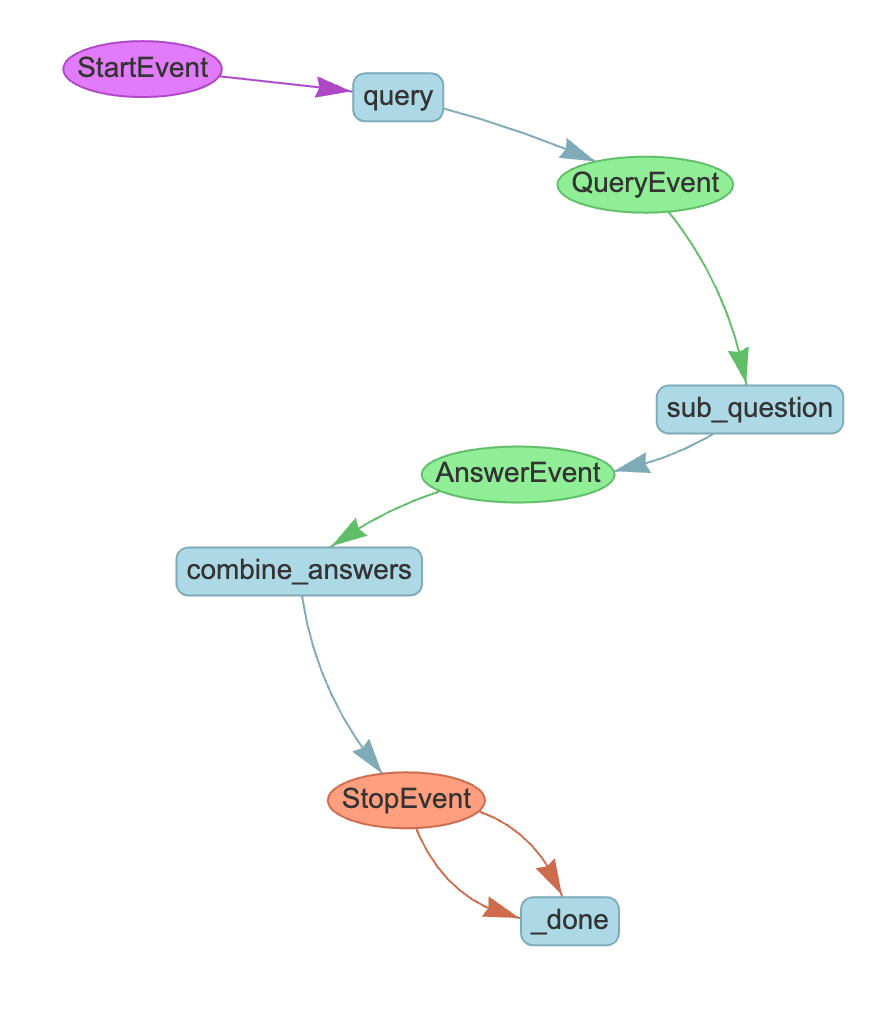

## Load Data

We will use a sample news article dataset retrieved from Diffbot, which Tomaz has conveniently made available on GitHub for easy access.

The dataset contains 2,500 samples; for ease of experimentation, we will use 50 of these samples, which include the `title` and `text` of news articles.

In [8]:
news = pd.read_csv(
    "https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/news_articles.csv"
)[:50]

news.head()

,title,date,text
0,Chevron: Best Of Breed,2031-04-06T01:36:32.000000000+00:00,JHVEPhoto Like many companies in the O&G secto...
1,FirstEnergy (NYSE:FE) Posts Earnings Results,2030-04-29T06:55:28.000000000+00:00,FirstEnergy (NYSE:FE – Get Rating) posted its ...
2,Dáil almost suspended after Sinn Féin TD put p...,2023-06-15T14:32:11.000000000+00:00,The Dáil was almost suspended on Thursday afte...
3,Epic’s latest tool can animate hyperrealistic ...,2023-06-15T14:00:00.000000000+00:00,"Today, Epic is releasing a new tool designed t..."
4,"EU to Ban Huawei, ZTE from Internal Commission...",2023-06-15T13:50:00.000000000+00:00,The European Commission is planning to ban equ...


##  Build End to End GraphRAG Pipeline

Now that we have defined all the necessary components, let’s intergrate everything and construct the GraphRAG pipeline:

1. Create nodes/chunks from the text.
2. Build a PropertyGraphIndex using `GraphRAGExtractor` and `GraphRAGStore`.
3. Construct communities and generate a summary for each community using the graph built above.
4. Create a `GraphRAGQueryEngine` and begin querying.

In [9]:
# folder = "./data/sf_budgets/"
# files = os.listdir(folder)

# documents = SimpleDirectoryReader(
#             input_files=[folder + file for file in files]
#         ).load_data()

documents = [
    Document(text=f"{row['title']}: {row['text']}")
    for i, row in news.iterrows()
]
splitter = SentenceSplitter(
    chunk_size=1024,
    chunk_overlap=20,
)
nodes = splitter.get_nodes_from_documents(documents)

In [10]:
len(nodes)

50

### Build ProperGraphIndex using `GraphRAGExtractor` and `GraphRAGStore`

In [11]:
KG_TRIPLET_EXTRACT_TMPL = """
-Goal-
Given a text document, identify all entities and their entity types from the text and all relationships among the identified entities.
Given the text, extract up to {max_knowledge_triplets} entity-relation triplets.

-Steps-
1. Identify all entities. For each identified entity, extract the following information:
- entity_name: Name of the entity, capitalized
- entity_type: Type of the entity
- entity_description: Comprehensive description of the entity's attributes and activities
Format each entity as ("entity"$$$$<entity_name>$$$$<entity_type>$$$$<entity_description>)

2. From the entities identified in step 1, identify all pairs of (source_entity, target_entity) that are *clearly related* to each other.
For each pair of related entities, extract the following information:
- source_entity: name of the source entity, as identified in step 1
- target_entity: name of the target entity, as identified in step 1
- relation: relationship between source_entity and target_entity
- relationship_description: explanation as to why you think the source entity and the target entity are related to each other

Format each relationship as ("relationship"$$$$<source_entity>$$$$<target_entity>$$$$<relation>$$$$<relationship_description>)

3. When finished, output.

-Real Data-
######################
text: {text}
######################
output:"""

In [12]:
entity_pattern = r'\("entity"\$\$\$\$"(.+?)"\$\$\$\$"(.+?)"\$\$\$\$"(.+?)"\)'
relationship_pattern = r'\("relationship"\$\$\$\$"(.+?)"\$\$\$\$"(.+?)"\$\$\$\$"(.+?)"\$\$\$\$"(.+?)"\)'


def parse_fn(response_str: str) -> Any:
    entities = re.findall(entity_pattern, response_str)
    relationships = re.findall(relationship_pattern, response_str)
    return entities, relationships


kg_extractor = GraphRAGExtractor(
    llm=llm,
    extract_prompt=KG_TRIPLET_EXTRACT_TMPL,
    max_paths_per_chunk=2,
    parse_fn=parse_fn,
)

## Docker Setup And Neo4J setup

To launch Neo4j locally, first ensure you have docker installed. Then, you can launch the database with the following docker command.

```
docker run \
    -p 7474:7474 -p 7687:7687 \
    -v $PWD/data:/data -v $PWD/plugins:/plugins \
    --name neo4j-apoc \
    -e NEO4J_apoc_export_file_enabled=true \
    -e NEO4J_apoc_import_file_enabled=true \
    -e NEO4J_apoc_import_file_use__neo4j__config=true \
    -e NEO4JLABS_PLUGINS=\[\"apoc\"\] \
    neo4j:latest
```
From here, you can open the db at http://localhost:7474/. On this page, you will be asked to sign in. Use the default username/password of neo4j and neo4j.

Once you login for the first time, you will be asked to change the password.

In [14]:
graph_store = GraphRAGStore(
    username="neo4j", password="fractal-tripod-agenda-appear-brenda-2693", url="bolt://localhost:7687"
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [15]:
from llama_index.core import PropertyGraphIndex

index = PropertyGraphIndex(
    nodes=nodes,
    kg_extractors=[kg_extractor],
    property_graph_store=graph_store,
    show_progress=True,
)

Generating embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]
Generating embeddings: 0it [00:00, ?it/s]
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The procedure has a deprecated field. ('config' used by 'apoc.meta.graphSample' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: "CALL apoc.meta.graphSample() YIELD nodes, relationships RETURN nodes, [rel in relationships | {name:apoc.any.property(rel, 'type'), count: apoc.any.property(rel, 'count')}] AS relationships"


In [16]:
index.property_graph_store.get_triplets()

[[EntityNode(label='Company', embedding=None, properties={'id': 'Chevron', 'entity_description': 'Chevron is a company in the O&G sector. Its stock has declined about 10% over the past 90 days despite the fact that Q2 consensus earnings estimates have risen sharply (~25%) during that same time frame. Over the years, Chevron has kept a very strong balance sheet.', 'triplet_source_id': '848bd9df-b6ee-45b1-8c9d-08db27e28f6f'}, name='Chevron'),
  Relation(label='Owns', source_id='Chevron', target_id="Chevron's stock", properties={'relationship_description': "Chevron's stock represents ownership in Chevron.", 'triplet_source_id': '848bd9df-b6ee-45b1-8c9d-08db27e28f6f'}),
  EntityNode(label='Financial Instrument', embedding=None, properties={'id': "Chevron's stock", 'entity_description': "Chevron's stock is a financial instrument that represents ownership in Chevron. It has declined about 10% over the past 90 days despite the fact that Q2 consensus earnings estimates have risen sharply (~25%

### Build communities

This will create communities and summary for each community.

In [17]:
index.property_graph_store.build_communities()

### Create QueryEngine

In [18]:
query_engine = GraphRAGQueryEngine(
    graph_store=index.property_graph_store,
    llm=llm,
    index=index,
    similarity_top_k=10,
)

# Load data and run the workflow

Just like using the built-in Sub-Question Query Engine, we create our query tools and instantiate an LLM and pass them in.

Each tool is its own query engine based on a single (very lengthy) San Francisco budget document, each of which is 300+ pages. To save time on repeated runs, we persist our generated indexes to disk.

In [26]:
query_engine_tools = []

folder = "./data/sf_budgets/"
files = os.listdir(folder)

# TODO: Use graphRAG/Auto Retrieval to replace these
# TODO: Embed document summaries and map that to the set of raw chunks for each document.
# During query-time, do recursive retrieval to first fetch summaries before fetching documents.

for file in files:
    year = file.split(" - ")[0]
    index_persist_path = f"./storage/budget-{year}/"

    if os.path.exists(index_persist_path):
        storage_context = StorageContext.from_defaults(
            persist_dir=index_persist_path
        )
        index = load_index_from_storage(storage_context)
    else:
        documents = SimpleDirectoryReader(
            input_files=[folder + file]
        ).load_data()
        index = VectorStoreIndex.from_documents(documents)
        index.storage_context.persist(index_persist_path)

    engine = index.as_query_engine()
    query_engine_tools.append(
        QueryEngineTool(
            query_engine=engine,
            metadata=ToolMetadata(
                name=f"budget_{year}",
                description=f"Information about San Francisco's budget in {year}",
            ),
        )
    )

print(cache)

engine = SubQuestionQueryEngine(timeout=120, verbose=True)
result = await engine.run(
    llm=llm,
    tools=query_engine_tools,
    query="How has the total amount of San Francisco's budget changed from 2016 to 2023?",
)

print(result)

{}
Running step query
Query is How has the total amount of San Francisco's budget changed from 2016 to 2023?
Sub-questions are  {
                "sub_questions": [
                    "What was the total budget of San Francisco in 2016?",
                    "What was the total budget of San Francisco in 2017?",
                    "What was the total budget of San Francisco in 2018?",
                    "What was the total budget of San Francisco in 2019?",
                    "What was the total budget of San Francisco in 2020?",
                    "What was the total budget of San Francisco in 2021?",
                    "What was the total budget of San Francisco in 2022?",
                    "What was the total budget of San Francisco in 2023?"
                ]
            }
Step query produced no event
Running step sub_question
Sub-question is What was the total budget of San Francisco in 2016?
Found the key 2016
Cache miss for key 2016
> Running step fe155b85-8f68-46e6-b5e2

Our debug output is lengthy! You can see the sub-questions being generated and then `sub_question()` being repeatedly invoked, each time generating a brief log of ReAct agent thoughts and actions to answer each smaller question.

You can see `combine_answers` running multiple times; these were triggered by each `AnswerEvent` but before all 8 `AnswerEvents` were collected. On its final run it generates a full prompt, combines the answers and returns the result.

In [27]:
query_engine_tools = []

folder = "./data/sf_budgets/"
files = os.listdir(folder)

# TODO: Use graphRAG/Auto Retrieval to replace these
# TODO: Embed document summaries and map that to the set of raw chunks for each document.
# During query-time, do recursive retrieval to first fetch summaries before fetching documents.

for file in files:
    year = file.split(" - ")[0]
    index_persist_path = f"./storage/budget-{year}/"

    if os.path.exists(index_persist_path):
        storage_context = StorageContext.from_defaults(
            persist_dir=index_persist_path
        )
        index = load_index_from_storage(storage_context)
    else:
        documents = SimpleDirectoryReader(
            input_files=[folder + file]
        ).load_data()
        index = VectorStoreIndex.from_documents(documents)
        index.storage_context.persist(index_persist_path)

    engine = index.as_query_engine()
    query_engine_tools.append(
        QueryEngineTool(
            query_engine=engine,
            metadata=ToolMetadata(
                name=f"budget_{year}",
                description=f"Information about San Francisco's budget in {year}",
            ),
        )
    )

print(cache)

engine = SubQuestionQueryEngine(timeout=120, verbose=True)
result = await engine.run(
    llm=llm,
    tools=query_engine_tools,
    query="How has the total amount of San Francisco's budget changed from 2016 to 2023?",
)

print(result)

{'2016': 'The total budget of San Francisco for Fiscal Year 2016-17 was $9.6 billion.', '2017': 'The total budget of San Francisco for FY 2017-18 was $10.1 billion.', '2018': 'The total budget of San Francisco in 2018 was $11,039,195,070.', '2019': 'The total budget of San Francisco in 2019 was $4,033,595,450.', '2020': "I'm sorry, but I don't have information about San Francisco's budget for 2020.", '2021': 'The total budget of San Francisco in 2021 was $12,433,531,016.', '2022': 'The total budget of San Francisco for the fiscal year 2021-2022 was $13,248,709,511.', '2023': 'The total budget of San Francisco for Fiscal Year 2023-24 is $14.6 billion.'}
Running step query
Query is How has the total amount of San Francisco's budget changed from 2016 to 2023?
Sub-questions are  {
                "sub_questions": [
                    "What was the total budget of San Francisco in 2016?",
                    "What was the total budget of San Francisco in 2017?",
                    "What w